In [31]:
from itertools import product

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm_notebook as tqdm_n

tqdm_n().pandas()

# INTRNLP MCO: Twitter Emoji Prediction
# Model
In this step, we build the classification model for predicting appropriate emoji given a tweet.

Note: Some of the "magic" cells contain Bash shell commands; these may not work on all platforms. However, all cells important in producing the final output have been written in Python for portability.

In [2]:
!ls data-clean

tokens_emotions.csv    tokens_spacy_clean.csv
tokens_spacy.csv       tweets.csv


# X: Features

We declare X as the list of cleaned tweets -- tokens joined back together by spaces. Each tweet is joined into a single string so that we can use them as input for scikit-learn's **vectorizers**.

Reading clean SpaCy-generated tokens from `tokens_spacy_clean.csv`

In [3]:
tokens = pd.read_csv('data-clean/tokens_spacy_clean.csv', dtype={'token':str}, keep_default_na=False)
tokens.head()

,index,token
0,0,vacation
1,0,waste
2,0,vacation2017
3,0,photobomb
4,0,tired


Combining groups of tokens back into single strings separated by space character (for use in sklearn vectorizers)

In [4]:
tokens = tokens.groupby('index').progress_apply(lambda x : ' '.join(x['token']))
tokens.head()

index
0    vacation waste vacation2017 photobomb tired va...
1    oh wynwood be so funny wynwood art itwas3am fl...
2    be friend since 7th grade look at now all foll...
3    this be what look like when someone love uncon...
4    rt this white family be invite to a black barb...
dtype: object

In [5]:
X = tokens.values

# y: Labels

Our labels are the original emoji labels found in `Train.csv`, containing 20 possible classes.

Reading tweet-emoji pairs from `tweets.csv`

In [6]:
tweets = pd.read_csv('data-clean/tweets.csv')
tweets.head()

,text,emoji
0,Vacation wasted ! #vacation2017 #photobomb #ti...,0
1,"Oh Wynwood, you’re so funny! : @user #Wynwood ...",1
2,Been friends since 7th grade. Look at us now w...,2
3,This is what it looks like when someone loves ...,3
4,RT @user this white family was invited to a Bl...,3


In [7]:
y = tweets['emoji'][tokens.index].values

# The Machine Learning Part : )

We experiment with permutations of the following:

Vectorizers
- Count
 - ngram_range (1,1), (1,2), (2,2)
 - max_df 0.95
 - min_df 1, 0.05
 - max_features None, 500, 1000, 1500
- Term Frequency (TfidfVectorizer with use_idf=False)
 - ngram_range (1,1), (1,2), (2,2)
 - max_df 0.95
 - min_df 1, 0.05
 - max_features None, 500, 1000, 1500
- Term Frequency-Inverse Document Frequency
 - ngram_range (1,1), (1,2), (2,2)
 - max_df 0.95
 - min_df 1, 0.05
 - max_features None, 500, 1000, 1500
 
Resampling
- None
- RandomOverSampler
- RandomUnderSampler

(random_state set to 42 for consistency)

Models
- MultinomialNB (works better with word count data)
- ComplementNB (works better with imbalanced datasets)
- LinearSVC (SVM with linear kernel)

To find the best combination, we use grid search (via scikit-learn's GridSearchCV) with cross-validation fold count of 3 per pipeline. Because the dataset is imbalanced before resampling, we use the weighted average F1 score as the metric to maximize.

In [71]:
param_sets = list(product(
    ((1,1),),
    (0.95,),
    (1, 0.05),
    (None, 1000)
))

vecs = [
    CountVectorizer(ngram_range=ps[0], max_df=ps[1], min_df=ps[2], max_features=ps[3]) for ps in param_sets
] + [
    TfidfVectorizer(ngram_range=ps[0], max_df=ps[1], min_df=ps[2], max_features=ps[3]) for ps in param_sets
]

len(vecs)

8

In [72]:
smps = [
    None,
    RandomUnderSampler(random_state=42)
]

len(smps)

2

In [83]:
clfs = [
#     MultinomialNB(),
#     ComplementNB(),
#     LinearSVC(max_iter=100) # SVMs slow with several classes -- around 2^(n classes) minimum dimensions
]

# Try: ensemble of everything vs. boosted individual models

len(clfs)

1

In [84]:
sample_pipeline = Pipeline([
    ('vec', None),
    ('smp', None),
    ('clf', None)
])

gscv = GridSearchCV(
    sample_pipeline, param_grid={
        'vec':vecs, 'smp':smps, 'clf':clfs
    }, scoring='f1_weighted', cv=3, 
    n_jobs=4, refit=True, return_train_score=True,
    verbose=2
)

gscv.fit(X, y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:  3.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None, steps=[('vec', None), ('smp', None), ('clf', None)]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'vec': [CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        ...max_iter=100,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=2)

In [85]:
gscv.best_score_

0.25529009089424665

In [86]:
gscv.best_estimator_.steps

[('vec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=0.95, max_features=None, min_df=1,
          ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
          stop_words=None, strip_accents=None, sublinear_tf=False,
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None)),
 ('smp', None),
 ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=100,
       multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
       verbose=0))]

In [88]:
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_smp,param_vec,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
4,12.435322,0.140047,0.881410,0.016858,"LinearSVC(C=1.0, class_weight=None, dual=True,...",None,"TfidfVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.254340,0.257828,0.253702,0.255290,0.001814,1,0.876709,0.878876,0.875742,0.877109,0.001310
1,31.370677,1.557316,0.879171,0.064659,"LinearSVC(C=1.0, class_weight=None, dual=True,...",None,"CountVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.236215,0.240655,0.241996,0.239622,0.002470,2,0.283028,0.279281,0.277838,0.280049,0.002187
5,14.772660,0.188603,0.844509,0.033933,"LinearSVC(C=1.0, class_weight=None, dual=True,...",None,"TfidfVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.237025,0.241111,0.239412,0.239183,0.001676,3,0.276077,0.272993,0.271608,0.273559,0.001868
0,21.848563,0.097402,0.888293,0.008745,"LinearSVC(C=1.0, class_weight=None, dual=True,...",None,"CountVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.237797,0.239357,0.235911,0.237689,0.001409,4,0.923417,0.924847,0.923429,0.923898,0.000671
12,6.009872,0.024284,0.919595,0.015036,"LinearSVC(C=1.0, class_weight=None, dual=True,...","RandomUnderSampler(random_state=42, ratio=None...","TfidfVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.180653,0.184857,0.185228,0.183580,0.002075,5,0.471549,0.483683,0.483389,0.479540,0.005652
13,5.369635,0.041161,0.852700,0.030516,"LinearSVC(C=1.0, class_weight=None, dual=True,...","RandomUnderSampler(random_state=42, ratio=None...","TfidfVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.172433,0.181194,0.172706,0.175444,0.004067,6,0.235540,0.228725,0.225326,0.229864,0.004247
9,11.189055,1.530141,0.986117,0.088892,"LinearSVC(C=1.0, class_weight=None, dual=True,...","RandomUnderSampler(random_state=42, ratio=None...","CountVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.169150,0.174485,0.169864,0.171166,0.002365,7,0.236271,0.230529,0.228795,0.231865,0.003195
8,8.888362,0.300539,0.853388,0.026723,"LinearSVC(C=1.0, class_weight=None, dual=True,...","RandomUnderSampler(random_state=42, ratio=None...","CountVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.168480,0.173363,0.171138,0.170994,0.001996,8,0.474472,0.488106,0.487931,0.483503,0.006386
3,28.241280,0.329981,0.782893,0.021985,"LinearSVC(C=1.0, class_weight=None, dual=True,...",None,"CountVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.100883,0.102362,0.101632,0.101626,0.000604,9,0.101340,0.102640,0.101935,0.101971,0.000531
2,28.489226,0.428426,0.883876,0.105167,"LinearSVC(C=1.0, class_weight=None, dual=True,...",None,"CountVectorizer(analyzer='word', binary=False,...","{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.101147,0.102259,0.101210,0.101539,0.000510,10,0.101670,0.102514,0.101817,0.102001,0.000368


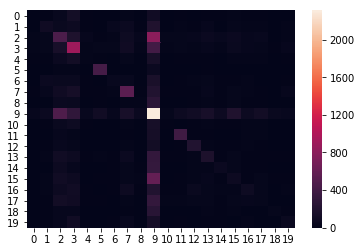

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

best_clf = gscv.best_estimator_
best_clf.fit(X_train, y_train)
sns.heatmap(confusion_matrix(y_test, best_clf.predict(X_test)))